In [2]:
import re
import itertools
import numpy as np
import pandas as pd
import skfuzzy as fuzz
import skfuzzy.control as ctrl
import matplotlib.pyplot as plt
from tabulate import tabulate

## Fuzzificação

C:\Users\yvesa\miniconda3\envs\fuzzy\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


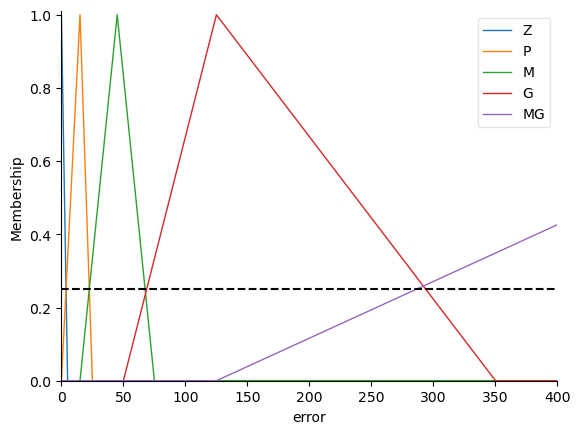

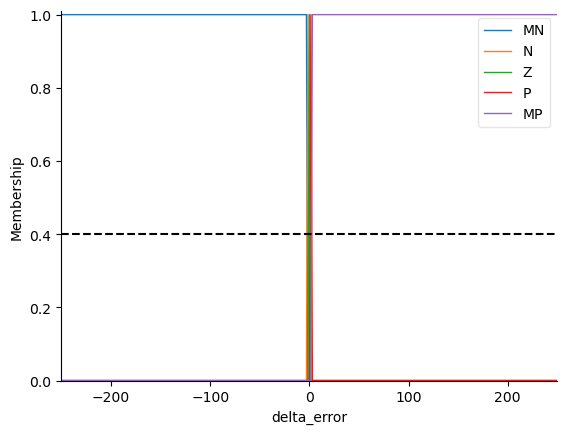

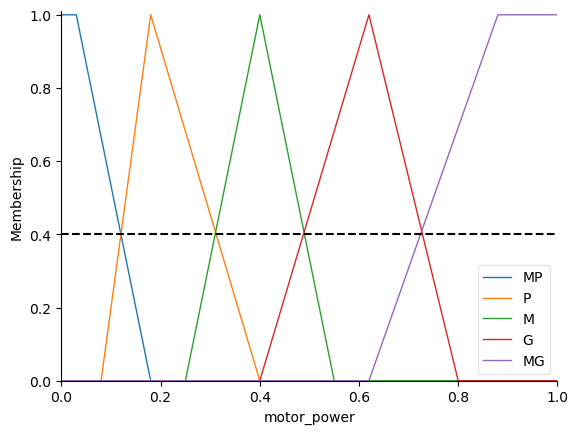

In [3]:
error = ctrl.Antecedent(np.arange(0, 1000.1, 0.1), 'error')
delta_error = ctrl.Antecedent(np.arange(-1000, 1000.5, 0.5), 'delta_error')
motor_power = ctrl.Consequent(np.arange(0, 1.01, 0.01), 'motor_power')

# Funções de pertinência
error['Z'] = fuzz.trimf(error.universe, [0, 0, 5])
error['P'] = fuzz.trimf(error.universe, [0, 15, 25])
error['M'] = fuzz.trimf(error.universe, [15, 45, 75])
error['G'] = fuzz.trimf(error.universe, [50, 125, 350])
error['MG'] = fuzz.trimf(error.universe, [125, 770, 1000])

delta_error['MN'] = fuzz.trapmf(delta_error.universe, [-1000, -1000, -3, -1.5])
delta_error['N'] = fuzz.trimf(delta_error.universe, [-3, -1.5, 0])
delta_error['Z'] = fuzz.trimf(delta_error.universe, [-1.5, 0, 1.5])
delta_error['P'] = fuzz.trimf(delta_error.universe, [0, 1.5, 3])
delta_error['MP'] = fuzz.trapmf(delta_error.universe, [1.5, 3, 1000, 1000])

motor_power['MP'] = fuzz.trapmf(motor_power.universe, [0, 0, 0.03, 0.18])
motor_power['P'] = fuzz.trimf(motor_power.universe, [0.08, 0.18, 0.4])
motor_power['M'] = fuzz.trimf(motor_power.universe, [0.25, 0.4, 0.55])
motor_power['G'] = fuzz.trimf(motor_power.universe, [0.4, 0.62, 0.8])
motor_power['MG'] = fuzz.trapmf(motor_power.universe, [0.62, 0.88, 1, 1])

error.view()
plt.axline((0, 0.25), (1000, 0.25), color='black', linestyle='--')
plt.xlim(0, 400)

delta_error.view()
plt.axline((0, 0.4), (1000, 0.4), color='black', linestyle='--')
plt.xlim(-250, 250)

motor_power.view()
plt.axline((0, 0.4), (1000, 0.4), color='black', linestyle='--')


## Base de Regras

In [4]:
power_result = [
    'MP', 'P', 'M', 'G', 'MG',
    'MP', 'P', 'M', 'M', 'M',
    'P', 'P', 'M', 'M', 'G',
    'P', 'M', 'M', 'G', 'G',
    'M', 'M', 'G', 'G', 'MG',
]

base_rules = [
    ctrl.Rule(error[Error] & delta_error[Delta_error], motor_power[Motor_power])
    for (Error, Delta_error), Motor_power in
    zip(itertools.product(error.terms.keys(), delta_error.terms.keys()), power_result)
]

In [5]:
ciano = '\033[96m'  # Define a cor azul-ciano

table = []
for Erro in error.terms:
    for Delta_erro in delta_error.terms:
        for regra in base_rules:
            antecedente = str(regra).split('IF ')[1].split(' THEN')[0].replace('AND ', '')
            consequente = str(regra).split('IF ')[1].split(' THEN')[1].split('AND ')[0]

            classificacoes = re.findall(r'\[(.*?)]', (antecedente + consequente))
            if Erro == classificacoes[0] and Delta_erro == classificacoes[1]:
                table.append([classificacoes[0], classificacoes[1], classificacoes[2]])
                break

df = pd.DataFrame(table, columns=[error.label, delta_error.label, motor_power.label])
pivot_table = pd.DataFrame(df.pivot(index=delta_error.label, columns=error.label, values=motor_power.label).reindex(
    index=delta_error.terms, columns=error.terms))
pivot_table.index.name = f'{ciano}{"E"}\033[0m'
print(tabulate(pivot_table, headers='keys', tablefmt='fancy_grid', stralign='center', showindex='always'))

╒═════╤═════╤═════╤═════╤═════╤══════╕
│  E  │  Z  │  P  │  M  │  G  │  MG  │
╞═════╪═════╪═════╪═════╪═════╪══════╡
│ MN  │ MP  │ MP  │  P  │  P  │  M   │
├─────┼─────┼─────┼─────┼─────┼──────┤
│  N  │  P  │  P  │  P  │  M  │  M   │
├─────┼─────┼─────┼─────┼─────┼──────┤
│  Z  │  M  │  M  │  M  │  M  │  G   │
├─────┼─────┼─────┼─────┼─────┼──────┤
│  P  │  G  │  M  │  M  │  G  │  G   │
├─────┼─────┼─────┼─────┼─────┼──────┤
│ MP  │ MG  │  M  │  G  │  G  │  MG  │
╘═════╧═════╧═════╧═════╧═════╧══════╛


700
689.2074874937709
679.3700520349458
669.650193998222
660.0465080935473
650.5576058269529
641.1821152998049
631.9186810104569
622.7659636582727
613.7226399499903
604.7874024084023
595.9589591833209
587.2360338648034
578.6173652986099
570.1017074038663
561.6878289929069
553.3745135932704
545.160559271823
537.0447784609837
529.0259977870269
521.1030579004363
513.2748133082879
505.54013220863465
497.89789632687166
490.3470007540569
482.88635378716435
475.51487677124595
468.2315039434809
461.0351822790882
453.92487133908116
446.8995431198415
439.95818190449137
433.0997841160416
426.32335817229523
419.6279243424855
413.0125146056271
406.47617251056
400.0179530376668
393.6369224622424
387.3321582194967
381.10274877117087
374.9477934737478
368.8664024482378
362.8576964515203
356.92080674922386
351.0548749901248
345.2590530820478
339.57864850050333
334.00833662668657
328.5434428900834
323.18001086922663
317.91379002304376
312.7413755964439
307.6594811090396
302.66485150887473
297.7547672869

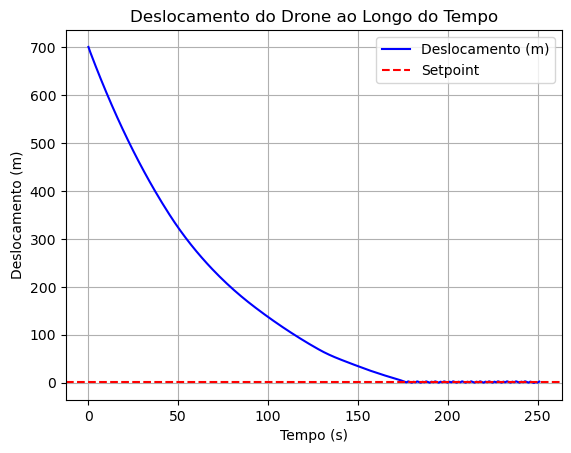

In [19]:
setpoint = 1
current_position = 700
time = 250
dt = 1
u_max = 4

error_control = ctrl.ControlSystemSimulation(ctrl.ControlSystem(base_rules))

positions = [current_position]
errors = [abs(setpoint - current_position)]

for t in range (time + 1):
    
    if current_position < setpoint:
        u_max = 6
    else:
        u_max = 4

    current_error = abs(setpoint - current_position)
    errors.append(current_error)
    
    print(current_position)

    if current_error < 10:
        fa = 0.984
    elif current_error < 25:
        fa = 0.994
    else:
        fa = 0.998

    current_delta_error = (errors[-1] - errors[-2])

    error_control.input['error'] = current_error
    error_control.input['delta_error'] = current_delta_error
    error_control.compute()

    p_motor = error_control.output['motor_power']

    if current_error > 5:
        p_h13 = p_motor
        p_h24 = p_motor
    else:
        p_h13 = 0.34
        p_h24 = 0.34

    d_t = fa * current_position * 1.01398 + 0.5 * (u_max * p_h13 + u_max * p_h24)

    if current_position < setpoint:
        current_position = d_t
    else:
        delta_movement = d_t - current_position
        current_position = current_position - delta_movement
        
    positions.append(current_position)

# Gráfico do deslocamento
plt.plot(range(len(positions)), positions, label='Deslocamento (m)', color='blue')
plt.axhline(setpoint, color='red', linestyle='--', label='Setpoint')
plt.xlabel('Tempo (s)')
plt.ylabel('Deslocamento (m)')
plt.title('Deslocamento do Drone ao Longo do Tempo')
plt.grid()
plt.legend()
plt.show()

# Considerações com Base no Enunciado
1.  Variação Máxima de Saída no Modo S-mode: O enunciado especifica uma velocidade máxima de descida (Umáx) de 4 m/s no S-mode. Essa velocidade máxima limita o quanto o drone pode descer por ciclo de tempo, o que representa o teto para a saída da potência.

2. Erro e Delta de Erro: Vamos definir o erro como uma variável que pode ser apenas positiva, representando a diferença entre a altura atual do drone e o ponto de referência (setPoint). Isso permite que o controle ajuste a velocidade de descida sempre em direção ao ponto alvo.

3. Controle Direto e Reverso em Pares de Motores: Os motores operam em pares e são ajustados por duas bases de regras, uma para o controle direto e outra para o controle reverso, que alternam a intensidade do ajuste para minimizar o erro.

# Construindo a Função de Transferência
Com essas definições, a função de transferência será usada para calcular a potência dos motores de forma proporcional ao erro e ao delta de erro, considerando a variação máxima de saída permitida no modo S-mode (4 m/s), adaptamos a função de transferência para ajustar a saída do controle fuzzy, sem precisar calcular um deslocamento acumulativo. Em vez disso, limitamos a resposta do controle à velocidade máxima permitida.